In [8]:
import os, datetime, argparse, requests, urllib.parse, sys, re, traceback, json
import pandas as pd
import time
import numpy as np

## Time series covid19 deaths global

In [9]:
file_folder = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series'
file_name = 'time_series_covid19_deaths_global.csv'
file_path = os.path.join(file_folder, file_name)

In [364]:
df = pd.read_csv(file_path)

In [365]:
#Drop columns/keep Country count only
df = df[df['Province/State'].isnull()].set_index('Country/Region')
df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)

### Daily deaths with coronavirus (7-day rolling average), by number of days since 3 daily deaths first recorded

In [366]:
# Rename columns with day since 1/22/20 instead of dates
dates_columns = df.columns
days_columns = ['day_{}'.format(i) for i in range(len(dates_columns))]
df.columns = days_columns

In [367]:
# Calculate consecutive difference (to get daily count) and transpose to have countries as columns
df = df.T.diff().T

In [368]:
## Remove countries which never had 3 daily deaths
df = df[(df > 2).sum(axis=1) > 0]

In [369]:
# For each country, determine first day with 3 deaths
first_day_threshold = (df > 2).idxmax(axis=1)
first_day = first_day_threshold.str.split('_',1).str[-1].astype(int).min()
chart_cols = ['{}'.format(i) for i in range(df.shape[1]-first_day)]

In [370]:
def pad_or_truncate(some_list, target_len):
    return some_list[:target_len] + [np.nan]*(target_len - len(some_list))

In [371]:
#Create shifted dataframe where first day is for each country 3 daily deaths first recorded 
df_chart = pd.DataFrame(columns=chart_cols)
for i, v in first_day_threshold.items():
    df_chart.loc[i] = pad_or_truncate(
        df.loc[i, first_day_threshold[i]:].to_list(), df_chart.shape[1])

In [372]:
# Calculate 7-day moving average
#df_chart_7 = df_chart.rolling(7,min_periods=1).mean().iloc[6:].reset_index(drop=True)
df_chart = df_chart.T
df_chart_7 = df_chart.rolling(7,min_periods=1).mean().reset_index(drop=True)

#### Plot

In [373]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})

In [374]:
country_selection = ['US', 'France', 'Italy', 'Spain', 'Germany', 'United Kingdom']

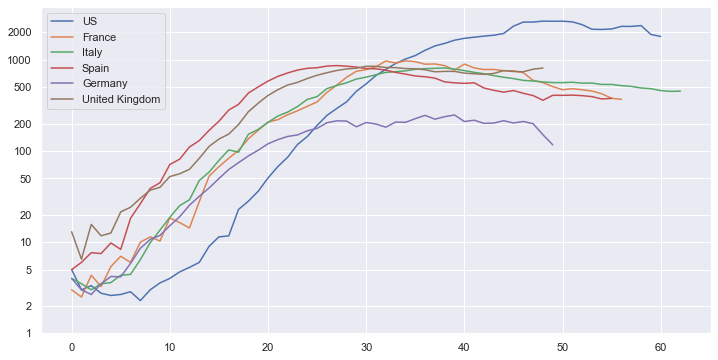

In [375]:
fig, ax = plt.subplots()
for country in country_selection:
    ax.plot(df_chart_7[country], label=country),
ax.set_yscale('log'),
ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.legend();